# 0. Module Import

In [1]:
import argparse
import sys
import time
import copy

import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_error

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, Dataset, DataLoader
import torch.optim as optim
from torch.autograd import Variable

from tqdm import tnrange, tqdm_notebook
import seaborn as sns
import matplotlib.pyplot as plt

# define functions for dMRI data preprocessing (reshape to matrix form, threshold ...)

In [2]:
def from_vec_form_to_mat_form(input_data):
    connectivity_matrix = np.zeros((84, 84))
    loc = 0
    for j in range(84):
        connectivity_matrix[j, j+1:] = input_data[loc:(loc+83-j)]
        loc += 83-j
    connectivity_matrix = connectivity_matrix + connectivity_matrix.T
    return connectivity_matrix     # type of this matrix is np.array

# matrix form connectivity data --> vector form data
def from_mat_form_to_vec_form(input_data):
    connectivity_line_form_data = np.zeros(int(len(input_data) * (len(input_data)-1) / 2))
    loc = 0
    for j in range(len(input_data)):
        connectivity_line_form_data[loc:(loc+len(input_data) - 1 - j)] = input_data[j, j + 1:]
        loc += len(input_data) - 1 -j
    return connectivity_line_form_data

def thresholding(input_data, threshold, NON):
    condition = input_data > 0
    p = len(input_data[condition]) * (1 - threshold) / (NON ** 2 - NON)
    return bct.threshold_proportional(input_data, p)

def absolute_threshold(input_data, threshold: int):
    # remove connection when streamline count below the threshold
    # math :: if streamline count <= threshold : streamline counts = 0

    thresholded_data = input_data.copy()
    condition = thresholded_data <= threshold
    thresholded_data[condition] = 0
    return thresholded_data

In [3]:
def column_dropout(input_df):
    # 한 column 내의 모든 element가 같은 값을 가지면, 거기에는 아무런 정보가 없으므로, 제거.
    
    survival_condition = (input_df.max() - input_df.min()) != 0
    column_dropouted_df = input_df.loc[:, survival_condition]
    survived_col = column_dropouted_df.columns
    return column_dropouted_df, survived_col

def df_z_scoring(input_df):
    df_mean = input_df.values.mean()
    df_std = input_df.values.std()
    z_scored_df = pd.DataFrame((input_df - df_mean).values / df_std, index=input_df.index, columns=input_df.columns)

    return z_scored_df

## argparse 이거 뭐하는거지?? 공부 필요함

In [48]:
parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.seed = 123
args.val_size = 0.1
args.test_size = 0.1
args.shuffle = True

adjacency matrix, feature matrix, label 이런 것들은 전부 다 list의 형태로 해야하나봄??

# 1. adjacency matrix
n_node X n_node dimension

1. from dMRI streamline count

2. threshold = 3

3. binarized

4. 1-d form --> 2-d symmetric matrix form
# 2. feature matrix
n_node rows X n_features columns dimension 

what features?

1. ROI identity --> L/R 구분 + one-hot encoding
L = 0으로, R=1으로 coding, + 42개 ROI 각각 one-hot encoding

2. morphometric data if possible to add

3. brain network measures
['deg', 'eccen', 'clust_coef', 'E_local', 'kcore_index_of','EC', 'BC', 'Cc', 'within_module_deg', 
                'avg_neigh_deg', 'participation_coef'] 를 node feature로 사용

# 3. labels
NIH total score를 사용

# data loading

In [5]:
# dMRI streamline count
st_brain_net = pd.read_csv('../../data/con_aparc_count.csv').set_index('subjectkey').dropna()
n_node = 84

# brain network measure data
brain_net_measures = pd.read_csv('../../data/v22_01_31_total_data_lin_ab1.csv').set_index('subjectkey').dropna()
brain_net_measures_bin = pd.read_csv('../../data/v22_01_30_total_data_binarized_ab1.csv').set_index('subjectkey').dropna()

# NIH score
NIH_data = pd.read_csv('../../data/demo.nih.cbcl.els.11875.csv').set_index('subjectkey').loc[:,:'nihtbx_picvocab_uncorrected'].dropna()
NIH_total = NIH_data['nihtbx_totalcomp_uncorrected']

# subjectlist
subject_list = st_brain_net.index & brain_net_measures.index & NIH_total.index & brain_net_measures_bin.index

st_brain_net = st_brain_net.loc[subject_list]
brain_net_measures = brain_net_measures.loc[subject_list]
brain_net_measures_bin = brain_net_measures_bin.loc[subject_list]
NIH_total = NIH_total.loc[subject_list]

brain_net_node_features = pd.DataFrame()


<ipython-input-5-a82b72ddc835>:14: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  subject_list = st_brain_net.index & brain_net_measures.index & NIH_total.index & brain_net_measures_bin.index


In [6]:

node_feature_list = ['deg', 'stren', 'eccen', 'clust_coef','EC', 'BC', 'Cc', 'within_module_deg', 'participation_coef', 'avg_neigh_stren']
node_feature_list_from_bin_data =['E_local', 'kcore_index_of', 'avg_neigh_deg']
node_index_start, node_index_end = 'L-BSTS', 'R-CER'

for node_feature in node_feature_list:
    print(node_feature)
    brain_net_node_features = pd.concat([brain_net_node_features, 
                                         df_z_scoring(brain_net_measures.loc[:, node_feature + '_' + node_index_start : node_feature + '_' + node_index_end])], axis=1)

for node_feature in node_feature_list_from_bin_data:
    print(node_feature)
    brain_net_node_features = pd.concat([brain_net_node_features,
                                         df_z_scoring(brain_net_measures_bin.loc[:, node_feature + '_' + node_index_start : node_feature + '_' + node_index_end])], 
                                        axis=1)
del brain_net_measures
del brain_net_measures_bin
del NIH_data

deg
stren
eccen
clust_coef
EC
BC
Cc
within_module_deg
participation_coef
avg_neigh_stren
E_local
kcore_index_of
avg_neigh_deg


In [7]:
# adjacency matrix :: threshold = 1, binarized graph
# identity matrix를 더해줬음. for GCN convolution calculation

adj_mat = np.zeros((len(st_brain_net), 84, 84))
for i in range(len(st_brain_net)):
    thresholded_data = absolute_threshold(st_brain_net.iloc[i], 1)
    adj_mat[i] = from_vec_form_to_mat_form(thresholded_data) + np.eye(n_node)
adj_mat = np.sign(adj_mat)
adj_mat

del st_brain_net

In [8]:
brain_net_node_features

,deg_L-BSTS,deg_L-CACG,deg_L-CMFG,deg_L-CU,deg_L-EC,deg_L-FG,deg_L-IPG,deg_L-ITG,deg_L-ICG,deg_L-LOG,...,avg_neigh_deg_R-RMFG,avg_neigh_deg_R-SFG,avg_neigh_deg_R-SPG,avg_neigh_deg_R-STG,avg_neigh_deg_R-SMG,avg_neigh_deg_R-FP,avg_neigh_deg_R-TP,avg_neigh_deg_R-TTG,avg_neigh_deg_R-IN,avg_neigh_deg_R-CER
subjectkey,,,,,,,,,,,,,,,,,,,,,
NDARINV58P78T2W,-0.566807,-0.357437,0.689411,-0.636596,-2.102184,0.549832,1.038361,1.177941,0.759201,0.340462,...,0.761396,1.048432,0.883487,0.563050,1.090293,1.406934,0.077044,2.519699,0.249757,1.622249
NDARINV6VFFYA3R,-1.055336,0.061302,0.759201,-0.845966,-2.311554,-0.636596,0.549832,-0.217857,0.689411,0.061302,...,-0.593805,-0.769061,-0.890972,-0.294400,0.582451,-1.083972,-0.330066,1.470262,-0.815779,0.629135
NDARINVNW7JFAN8,-0.427227,-1.264705,0.410252,-0.427227,-2.241764,-0.078277,0.968571,0.619622,0.898781,0.200882,...,-0.684111,-0.104635,-0.047694,0.338272,0.656556,1.976887,-1.880370,1.477569,-0.432065,1.513510
NDARINV7GTT6FAU,-0.217857,-0.287647,0.968571,-0.776176,-1.892814,0.061302,1.038361,-0.008487,1.387310,0.270672,...,0.046887,0.192643,0.169600,0.303215,1.026965,0.886236,-1.189518,1.313921,-0.202345,0.651688
NDARINV7DWZAMUR,-0.636596,-0.357437,0.200882,-0.845966,-1.892814,1.387310,1.247730,0.480042,0.689411,0.689411,...,-0.349941,0.005544,0.172538,0.102375,1.158401,0.947805,0.406878,1.855102,-0.316027,1.047176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NDARINVZJ7AEU7T,-0.148067,-0.497017,0.968571,-0.566807,-1.892814,0.131092,0.968571,0.549832,1.177941,0.340462,...,1.606578,0.938492,0.769982,0.946366,2.140861,1.495043,0.330356,2.791105,0.628903,1.758757
NDARINV6YFHHNGB,-0.008487,0.061302,0.759201,-1.055336,-2.102184,-0.217857,1.457100,0.340462,0.689411,-0.915756,...,-0.226931,0.204811,-0.022202,0.088352,0.557112,-1.347839,-0.160437,1.575294,-0.151912,0.059453
NDARINVH9DY5DU5,-0.845966,-0.915756,0.549832,-0.008487,-2.032394,0.480042,1.038361,-0.217857,1.108151,0.270672,...,0.022240,-0.201216,0.254554,0.318294,0.331487,1.897727,-0.165093,1.287063,-0.531403,1.383186


In [9]:
# node feature matrix
# feature : node_id + ['deg', 'eccen', 'clust_coef', 'E_local', 'kcore_index_of','EC', 'BC', 'Cc', 'within_module_deg', 
#                        'avg_neigh_deg', 'participation_coef']
# node_id : one-hot encoding
# 11 nodal brain network measures

# node_id
node_id = np.zeros((n_node, 43))
for i in range(len(node_id)):
    if i <= 41:
        node_id[i, i+1] = 1
    else:
        node_id[i, 0] = 1
        node_id[i, i-41] = 1

'''
n_node = 84
temporary_list_for_region_list = st_brain_net.columns.str.split('_')
region_list = []
region_list.append(temporary_list_for_region_list[0][1])
for i in range(n_node - 1):
    region_list.append(temporary_list_for_region_list[i][2])
col_list = ['R']
'''
feature_list = node_feature_list + node_feature_list_from_bin_data

feature_mat = np.zeros((len(adj_mat), n_node, len(node_id[0]) + len(feature_list)))
for i in range(len(adj_mat)):
    feature_mat[i, :, :43] = node_id
    for j in range(len(feature_list)):
        feature_mat[i, :, 43+j] = np.array(brain_net_node_features.loc[:,feature_list[j]+'_L-BSTS' : feature_list[j]+'_R-CER'].iloc[i])

In [10]:
feature_mat.shape

(9220, 84, 56)

In [11]:
pd.DataFrame(feature_mat[1000])

,0,1,2,3,4,5,6,7,8,9,...,46,47,48,49,50,51,52,53,54,55
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.128080,-0.651314,-0.508610,0.195643,0.054931,2.102714,0.316099,1.094145,0.622190,1.786902
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.674646,-0.423064,-0.508610,0.661390,-0.932055,0.638493,2.221672,0.666670,0.803987,1.574668
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.320285,1.455863,-0.508610,1.598511,-0.136623,0.556089,3.534423,0.218959,0.803987,1.560908
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.439991,-0.728969,-0.508610,-0.233257,-0.581246,1.400785,0.693622,0.572107,0.440393,1.266585
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.319134,-0.942160,-0.508610,-0.572775,-0.468086,0.768508,-1.429647,1.363287,-1.741171,0.800793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.283713,-0.980369,-0.508610,-0.885951,-1.306209,-1.717359,0.864270,2.762824,-4.649924,-0.160437
80,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.175459,-0.973539,-0.508610,-0.667700,-1.012411,0.762169,-1.399037,2.608463,-2.286563,1.064217
81,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.613543,-0.975316,-0.508610,-1.250009,-1.069186,0.523114,-0.959546,2.045113,-0.468592,1.953432
82,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.709712,-0.299817,0.412218,1.209918,-0.363168,1.232041,0.873784,-0.221483,0.803987,0.643343


In [79]:
class GCNDataset(Dataset):
    def __init__(self, list_feature, list_adj, list_NIH_score):
        self.list_feature = list_feature
        self.list_adj = list_adj
        self.list_NIH_score = list_NIH_score
    
    def __len__(self):
        return len(self.list_feature)
    
    def __getitem__(self, index):
        return self.list_feature[index], self.list_adj[index], self.list_NIH_score[index]
    
    
def partition(list_feature, list_adj, list_NIH_score, args):
    num_total = len(list_feature)
    num_train = int(num_total * (1 - args.test_size - args.val_size))
    num_val = int(num_total * args.val_size)
    num_test = int(num_total * args.test_size)
    
    feature_train = list_feature[:num_train]
    adj_train = list_adj[:num_train]
    NIH_score_train = list_NIH_score[:num_train]
    feature_val = list_feature[num_train:num_train + num_val]
    adj_val = list_adj[num_train:num_train + num_val]
    NIH_score_val = list_NIH_score[num_train:num_train + num_val]
    feature_test = list_feature[num_total - num_test:]
    adj_test = list_adj[num_total - num_test:]
    NIH_score_test = list_NIH_score[num_total - num_test:]
    
    train_set = GCNDataset(feature_train, adj_train, NIH_score_train)
    val_set = GCNDataset(feature_val, adj_val, NIH_score_val)
    test_set = GCNDataset(feature_test, adj_test, NIH_score_test)
    
    partition = {
        'train' : train_set,
        'val' : val_set,
        'test': test_set
    }
    
    return partition

In [80]:
class SkipConnection(nn.Module):
    
    def __init__(self, in_dim, out_dim):
        super(SkipConnection, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.linear = nn.Linear(in_dim, out_dim, bias=False)
        
    def forward(self, in_x, out_x):
        if (self.in_dim != self.out_dim):   # dimension이 다르면 dimension을 맞춰주는 작업
            in_x = self.linear(in_x)
        out = in_x + out_x
        return out

In [174]:
class GatedSkipConnection(nn.Module):
    
    def __init__(self, in_dim, out_dim):
        super(GatedSkipConnection, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.linear = nn.Linear(in_dim, out_dim, bias=False)  # 왜 bias를 안 주는 것일까?
        self.linear_coef_in = nn.Linear(out_dim, out_dim)
        self.linear_coef_out = nn.Linear(out_dim, out_dim)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, in_x, out_x):
        if (self.in_dim != self.out_dim):
            in_x = self.linear(in_x)
        z = self.gate_coefficient(in_x, out_x)
        out = torch.mul(z, out_x) + torch.mul(1.0 - z, in_x)
        return out
    
    def gate_coefficient(self, in_x, out_x):
        x1 = self.linear_coef_in(in_x)
        x2 = self.linear_coef_out(out_x)
        return self.sigmoid(x1+x2)

In [170]:
class Attention(nn.Module):   ## Attention에 대해서 좀 더 알아볼 필요가 있을 듯. 일단 데이터 돌리고.
    
    def __init__(self, in_dim, output_dim, num_head):
        super(Attention, self).__init__()
        
        self.num_head = num_head
        self.atn_dim = output_dim // num_head
        
        self.linears = nn.ModuleList()
        self.corelations = nn.ParameterList()
        for i in range(self.num_head):
            self.linears.append(nn.Linear(in_dim, self.atn_dim))
            corelation = torch.FloatTensor(self.atn_dim, self.atn_dim)
            nn.init.xavier_uniform_(corelation)
            self.corelations.append(nn.Parameter(corelation))
            
        self.tanh = nn.Tanh()
        
    def forward(self, x, adj):
        heads = list()
        for i in range(self.num_head):
            x_transformed = self.linears[i](x)
            alpha = self.attention_matrix(x_transformed, self.corelations[i], adj)
            x_head = torch.matmul(alpha, x_transformed)
            heads.append(x_head)
        output = torch.cat(heads, dim=2)
        return output
    
    def attention_matrix(self, x_transformed, corelation, adj):
        x = torch.einsum('akj, ij->aki', (x_transformed, corelation))
        alpha = torch.matmul(x, torch.transpose(x_transformed, 1, 2))
        alpha = torch.mul(alpha, adj)
        alpha = self.tanh(alpha)
        return alpha

In [83]:
class GCNLayer(nn.Module):
    
    def __init__(self, in_dim, out_dim, n_node, act=None, bn=False, atn=False, num_head=1, dropout=0):
        super(GCNLayer, self).__init__()
        
        self.use_bn = bn
        self.use_atn = atn
        self.linear = nn.Linear(in_dim, out_dim)
        nn.init.xavier_uniform_(self.linear.weight)    # 이 부분도
        self.bn = nn.BatchNorm1d(n_node)
        self.attention = Attention(out_dim, out_dim, num_head)    # 이 부분 잘 이해가 안 감 --> 아! Attention이라는 것을 정의를 했구나!
        self.activation = act
        self.dropout_rate = dropout
        self.dropout = nn.Dropout2d(self.dropout_rate)
        
        # num_head가 뭐지??
    def forward(self, x, adj):
        out = self.linear(x)
        if self.use_atn:
            out = self.attention(out, adj)
        else:
            out = torch.matmul(adj, out)
        if self.use_bn:
            out = self.bn(out)
        if self.activation != None:
            out = self.activation(out)
        if self.dropout_rate > 0:
            out = self.dropout(out)
        return out, adj

In [84]:
class GCNBlock(nn.Module):
    def __init__(self, n_layer, in_dim, hidden_dim, out_dim, n_node, bn=True, atn=True, num_head=1, sc='gsc', dropout=0):
        super(GCNBlock, self).__init__()
        
        self.layers = nn.ModuleList()
        for i in range(n_layer):
            self.layers.append(GCNLayer(in_dim if i==0 else hidden_dim,
                                       out_dim if i==n_layer-1 else hidden_dim,
                                       n_node,
                                       nn.ReLU() if i != n_layer-1 else None,
                                       bn,
                                       atn,
                                       num_head,
                                       dropout))
        
        self.relu = nn.ReLU()
        if sc=='gsc':
            self.sc = GatedSkipConnection(in_dim, out_dim)
        elif sc =='sc':
            self.sc = SkipConnection(in_dim, out_dim)
        elif sc=='no':
            self.sc = None
        else:
            assert False, "Wrong sc type."
    
    def forward(self, x, adj):
        residual = x
        for i, layer in enumerate(self.layers):
            out, adj = layer((x if i==0 else out), adj)
        if self.sc != None:
            out = self.sc(residual, out)
        out = self.relu(out)
        return out, adj
        

In [85]:
class ReadOut(nn.Module):
    
    def __init__(self, in_dim, out_dim, act=None):
        super(ReadOut, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.linear = nn.Linear(self.in_dim,
                               self.out_dim)
        nn.init.xavier_uniform_(self.linear.weight)   # activation function 따라 다른 방식의 initialization을 쓸 수 있음.
        self.activation = act
        
    def forward(self, x):
        out = self.linear(x)
        out = torch.sum(out, 1)
        if self.activation != None:
            out = self.activation(out)
        return out

In [86]:
class Predictor(nn.Module):
    
    def __init__(self, in_dim, out_dim, act=None):
        super(Predictor, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.linear = nn.Linear(self.in_dim,
                               self.out_dim)
        nn.init.xavier_uniform_(self.linear.weight)
        self.activation = act
        
    def forward(self, x):
        out = self.linear(x)
        if self.activation != None:
            out = self.activation(out)
        return out

In [87]:
class GCNNet(nn.Module):
    def __init__(self, args):
        super(GCNNet, self).__init__()
        
        self.blocks = nn.ModuleList()
        for i in range(args.n_block):
            self.blocks.append(GCNBlock(args.n_layer,
                                      args.in_dim if i==0 else args.hidden_dim,
                                       args.hidden_dim,
                                       args.hidden_dim,
                                       args.n_node,
                                        args.bn,
                                        args.atn,
                                        args.num_head,
                                        args.sc,
                                        args.dropout
                                       ))
            self.readout = ReadOut(args.hidden_dim,
                                  args.pred_dim1,
                                   act=nn.ReLU())
            self.pred1 = Predictor(args.pred_dim1,
                                  args.pred_dim2,
                                  act=nn.ReLU())
            self.pred2 = Predictor(args.pred_dim2,
                                  args.pred_dim3,
                                  act=nn.Tanh())
            self.pred3 = Predictor(args.pred_dim3,
                                  args.out_dim)
            
    def forward(self, x, adj):
        for i, block in enumerate(self.blocks):
            out, adj = block((x if i==0 else out), adj)
        out = self.readout(out)
        out = self.pred1(out)
        out = self.pred2(out)
        out = self.pred3(out)
        
        return out

# Train, Validate, and Test

In [95]:
def train(model, device, optimizer, criterion, data_train, bar, args):
    epoch_train_loss = 0
    for i, batch in enumerate(data_train):
        list_feature = torch.tensor(batch[0]).to(device).float()
        list_adj = torch.tensor(batch[1]).to(device).float()
        list_NIH_score = torch.tensor(batch[2]).to(device).float()
        list_NIH_score = list_NIH_score.view(-1, 1)

        
        model.train()
        optimizer.zero_grad()
        list_pred_NIH_score = model(list_feature, list_adj)
        list_pred_NIH_score.require_grad = False
        train_loss = criterion(list_pred_NIH_score, list_NIH_score)
        epoch_train_loss += train_loss.item()
        train_loss.backward()
        optimizer.step()
        
        bar.update(len(list_feature))
        
    epoch_train_loss /= len(data_train)
    
    return model, epoch_train_loss

In [96]:
def validate(model, device, criterion, data_val, bar, args):
    epoch_val_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(data_val):
            list_feature = torch.tensor(batch[0]).to(device).float()
            list_adj = torch.tensor(batch[1]).to(device).float()
            list_NIH_score = torch.tensor(batch[2]).to(device).float()
            list_NIH_score = list_NIH_score.view(-1,1)

            model.eval()
            list_pred_NIH_score = model(list_feature, list_adj)
            list_pred_NIH_score.require_grad = False
            val_loss = criterion(list_pred_NIH_score, list_NIH_score)
            epoch_val_loss += val_loss.item()
            
            bar.update(len(list_feature))

    epoch_val_loss /= len(data_val)
    
    return model, epoch_val_loss

In [97]:
def test(model, device, data_test, args):
    model.eval()
    with torch.no_grad():
        NIH_score_total = list()
        pred_NIH_score_total = list()
        for i, batch in enumerate(data_test):
            list_feature = torch.tensor(batch[0]).to(device).float()
            list_adj = torch.tensor(batch[1]).to(device).float()
            list_NIH_score = torch.tensor(batch[2]).to(device).float()
            NIH_score_total += list_NIH_score.tolist()
            list_NIH_score = list_NIH_score.view(-1,1)

            list_pred_NIH_score = model(list_feature, list_adj)
            pred_NIH_score_total += list_pred_NIH_score.view(-1).tolist()

        mae = mean_absolute_error(NIH_score_total, pred_NIH_score_total)
        std = np.std(np.array(NIH_score_total)-np.array(pred_NIH_score_total))
        
    return mae, std, NIH_score_total, pred_NIH_score_total

In [98]:
def experiment(dict_partition, device, bar, args):
    time_start = time.time()
    
    model = GCNNet(args)
    model.to(device)
        
    if args.optim == 'Adam':
        optimizer = optim.Adam(model.parameters(),
                               lr=args.lr,
                               weight_decay=args.l2_coef)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(),
                               lr=args.lr,
                               weight_decay=args.l2_coef)
    elif args.optim == 'SGD':
        optimizer = optim.SGD(model.parameters(),
                               lr=args.lr,
                               weight_decay=args.l2_coef)
    else:
        assert False, 'Undefined Optimizer Type'
        
    criterion = nn.MSELoss()
    scheduler = optim.lr_scheduler.StepLR(optimizer,
                                          step_size=args.step_size,
                                          gamma=args.gamma)

    list_train_loss = list()
    list_val_loss = list()

    data_train = DataLoader(dict_partition['train'], 
                            batch_size=args.batch_size,
                            shuffle=args.shuffle)

    data_val = DataLoader(dict_partition['val'],
                          batch_size=args.batch_size,
                          shuffle=args.shuffle)

    for epoch in range(args.epoch):

        scheduler.step()
        model, train_loss = train(model, device, optimizer, criterion, data_train, bar, args)
        list_train_loss.append(train_loss)
        model, val_loss = validate(model, device, criterion, data_val, bar, args)
        list_val_loss.append(val_loss)

    data_test = DataLoader(dict_partition['test'],
                           batch_size=args.batch_size,
                           shuffle=args.shuffle)

    mae, std, NIH_score_total, pred_NIH_score_total = test(model, device, data_test, args)
        
    time_end = time.time()
    time_required = time_end - time_start
    
    args.list_train_loss = list_train_loss
    args.list_val_loss = list_val_loss
    args.NIH_score_total = NIH_score_total
    args.pred_NIH_score_total = pred_NIH_score_total
    args.mae = mae
    args.std = std
    args.time_required = time_required
    
    return args

# 5.1 Experiment 1. lr vs n_block

In [99]:
args.batch_size = 128
args.lr = 0.0001
args.l2_coef = 0
args.optim = 'Adam'
args.epoch = 30
args.n_block = 2
args.n_layer = 2
args.n_node = 84
args.in_dim = 56
args.hidden_dim = 64
args.pred_dim1 = 256
args.pred_dim2 = 128
args.pred_dim3 = 128
args.out_dim = 1
args.bn = True
args.sc = 'no'
args.atn = False
args.step_size = 10
args.gamma = 0.1
args.dropout = 0
args.num_head = 8


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [100]:
list_lr = [0.01, 0.001, 0.0001, 0.00001]
list_n_block = [1, 2, 3]
#list_lr = [0.001]
#list_n_block = [2]
var1 = "lr"
var2 = "n_block"

dict_result = dict()
n_iter = len(list_n_block)*len(list_lr)*args.epoch*(len(dict_partition['train'])+len(dict_partition['val']))
bar = tqdm_notebook(total=n_iter, file=sys.stdout, position=0)

for lr in list_lr:
    for n_block in list_n_block:
        args.lr = lr
        args.n_block = n_block
        args.exp_name = var1+':'+str(lr)+'/'+var2+':'+str(n_block)
        result = vars(experiment(dict_partition, device, bar, args))
        print(args.exp_name + " took " + str(int(args.time_required)) + "seconds.")
        dict_result[args.exp_name] = copy.deepcopy(result)
        
        torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json('lr vs n_block 50000.JSON', orient='table')

<ipython-input-100-30eb93ab22b4>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  bar = tqdm_notebook(total=n_iter, file=sys.stdout, position=0)


  0%|          | 0/2987280 [00:00<?, ?it/s]

<ipython-input-95-b08feb65745c>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_feature = torch.tensor(batch[0]).to(device).float()
<ipython-input-95-b08feb65745c>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_adj = torch.tensor(batch[1]).to(device).float()
<ipython-input-95-b08feb65745c>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_NIH_score = torch.tensor(batch[2]).to(device).float()
<ipython-input-96-e536697e16be>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detac

lr:0.01/n_block:1 took 87seconds.


<ipython-input-96-e536697e16be>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_NIH_score = torch.tensor(batch[2]).to(device).float()
<ipython-input-97-660ea6a9ab59>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_adj = torch.tensor(batch[1]).to(device).float()
<ipython-input-97-660ea6a9ab59>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_NIH_score = torch.tensor(batch[2]).to(device).float()


lr:0.01/n_block:2 took 125seconds.


C:\Users\jungw\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
<ipython-input-95-b08feb65745c>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_feature = torch.tensor(batch[0]).to(device).float()
<ipython-input-95-b08feb65745c>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone()

lr:0.01/n_block:3 took 164seconds.


C:\Users\jungw\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
<ipython-input-95-b08feb65745c>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_feature = torch.tensor(batch[0]).to(device).float()
<ipython-input-95-b08feb65745c>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone()

lr:0.001/n_block:1 took 85seconds.


<ipython-input-96-e536697e16be>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_NIH_score = torch.tensor(batch[2]).to(device).float()
<ipython-input-97-660ea6a9ab59>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_adj = torch.tensor(batch[1]).to(device).float()
<ipython-input-97-660ea6a9ab59>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_NIH_score = torch.tensor(batch[2]).to(device).float()


lr:0.001/n_block:2 took 128seconds.


C:\Users\jungw\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
<ipython-input-95-b08feb65745c>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_feature = torch.tensor(batch[0]).to(device).float()
<ipython-input-95-b08feb65745c>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone()

lr:0.001/n_block:3 took 175seconds.


C:\Users\jungw\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
<ipython-input-95-b08feb65745c>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_feature = torch.tensor(batch[0]).to(device).float()
<ipython-input-95-b08feb65745c>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone()

lr:0.0001/n_block:1 took 88seconds.


<ipython-input-96-e536697e16be>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_NIH_score = torch.tensor(batch[2]).to(device).float()
<ipython-input-97-660ea6a9ab59>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_adj = torch.tensor(batch[1]).to(device).float()
<ipython-input-97-660ea6a9ab59>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_NIH_score = torch.tensor(batch[2]).to(device).float()


lr:0.0001/n_block:2 took 136seconds.


C:\Users\jungw\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
<ipython-input-95-b08feb65745c>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_feature = torch.tensor(batch[0]).to(device).float()
<ipython-input-95-b08feb65745c>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone()

lr:0.0001/n_block:3 took 172seconds.


<ipython-input-96-e536697e16be>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_NIH_score = torch.tensor(batch[2]).to(device).float()
<ipython-input-97-660ea6a9ab59>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_adj = torch.tensor(batch[1]).to(device).float()
<ipython-input-97-660ea6a9ab59>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_NIH_score = torch.tensor(batch[2]).to(device).float()


lr:1e-05/n_block:1 took 89seconds.


C:\Users\jungw\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
<ipython-input-95-b08feb65745c>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_feature = torch.tensor(batch[0]).to(device).float()
<ipython-input-95-b08feb65745c>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone()

lr:1e-05/n_block:2 took 131seconds.


C:\Users\jungw\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
<ipython-input-95-b08feb65745c>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_feature = torch.tensor(batch[0]).to(device).float()
<ipython-input-95-b08feb65745c>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone()

lr:1e-05/n_block:3 took 170seconds.


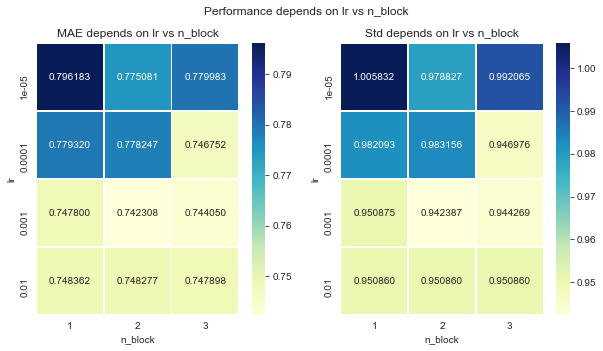

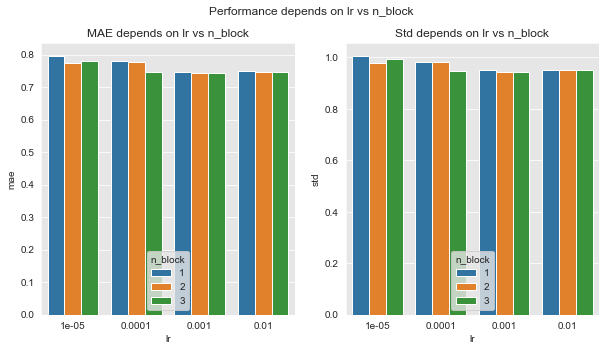

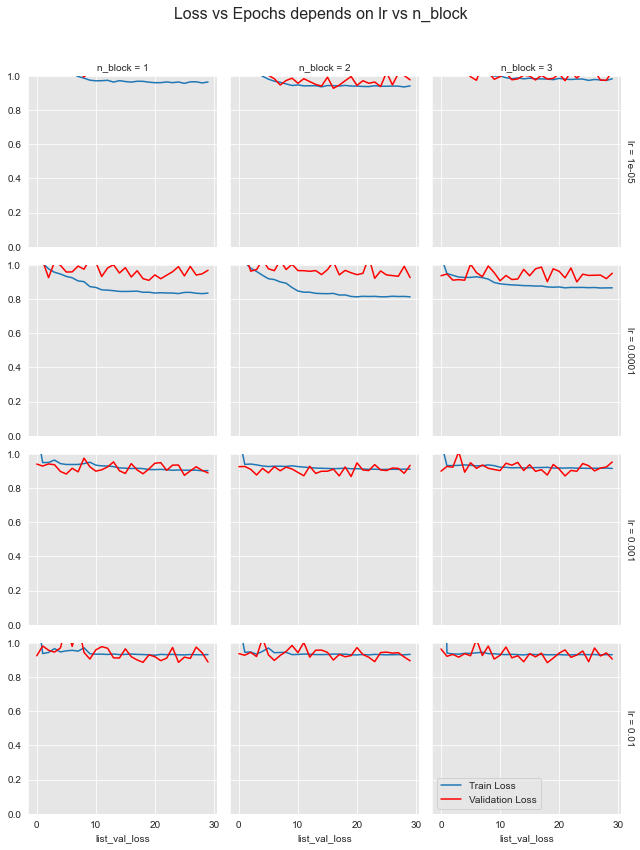

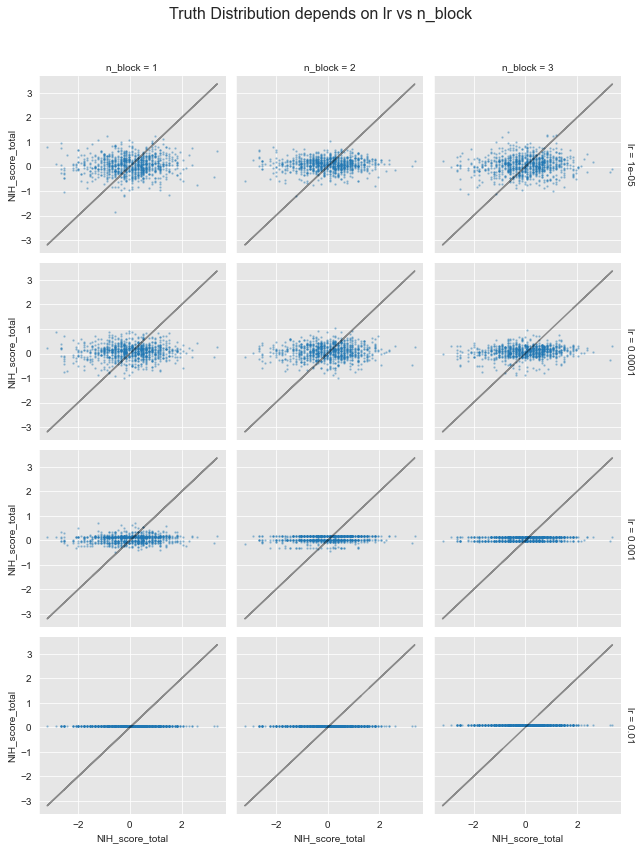

In [160]:
df_result = pd.read_json('lr vs n_block 50000.JSON', orient='table')
var1 = "lr"
var2 = "n_block"
plot_performance(df_result, var1, var2)
plot_performance_bar(df_result, var1, var2)
plot_loss(df_result, var1, var2)
plot_distribution(df_result, var1, var2)

In [155]:
df_mae = df_result.pivot(var1, var2, 'mae')
df_std = df_result.pivot(var1, var2, 'std')
df_mae[df_mae.columns].astype(float)
df_mae

n_block,1,2,3
lr,,,
0.00001,0.796183,0.775081,0.779983
0.00010,0.77932,0.778247,0.746752
0.00100,0.7478,0.742308,0.74405
0.01000,0.748362,0.748277,0.747898


In [156]:
df_mae.columns

Int64Index([1, 2, 3], dtype='int64', name='n_block')

In [158]:
df_mae[df_mae.columns].astype(float)

n_block,1,2,3
lr,,,
0.00001,0.796183,0.775081,0.779983
0.00010,0.779320,0.778247,0.746752
0.00100,0.747800,0.742308,0.744050
0.01000,0.748362,0.748277,0.747898


In [161]:
df_mae.astype(float)

n_block,1,2,3
lr,,,
0.00001,0.796183,0.775081,0.779983
0.00010,0.779320,0.778247,0.746752
0.00100,0.747800,0.742308,0.744050
0.01000,0.748362,0.748277,0.747898


# Results

optimal lr = 0.001\n
optimal n_block = 2

In [73]:
list_feature = list(feature_mat)
list_adj = list(adj_mat)
list_NIH_score = list(NIH_total)

dict_partition = partition(list_feature, list_adj, list_NIH_score, args)

In [74]:
len(dict_partition['train'])

7376

# Visualization

In [163]:
def plot_performance(df_result, var1, var2):
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(10, 5)
    
    df_mae = df_result.pivot(var1, var2, 'mae')
    df_std = df_result.pivot(var1, var2, 'std')
#    df_mae = df_mae[df_mae.columns].astype(float)
#    df_std = df_std[df_std.columns].astype(float)
    
    df_mae = df_mae.astype(float)
    df_std = df_std.astype(float)
    
    hm_mae = sns.heatmap(df_mae, ax=ax[0], annot=True, fmt='f', linewidths=.5, cmap='YlGnBu')
    hm_std = sns.heatmap(df_std, ax=ax[1], annot=True, fmt='f', linewidths=.5, cmap='YlGnBu')
    
    fig.suptitle('Performance depends on ' + var1 + ' vs ' + var2)
    hm_mae.set_title('MAE depends on ' + var1 + ' vs ' + var2)
    hm_std.set_title('Std depends on ' + var1 + ' vs ' + var2)   

In [102]:
def plot_performance_bar(df_result, var1, var2):
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(10, 5)
    
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    bar_mae = sns.barplot(x=var1, y='mae', hue=var2, data=df_result, ax=ax[0])
    bar_std = sns.barplot(x=var1, y='std', hue=var2, data=df_result, ax=ax[1])
    
    bar_mae.set_title('MAE depends on ' + var1 + ' vs ' + var2)
    bar_std.set_title('Std depends on ' + var1 + ' vs ' + var2)
    fig.suptitle('Performance depends on ' + var1 + ' vs ' + var2)

In [107]:
def plot_loss(df_result, var1, var2, ylim=1.0):
    def plot(x, ylim=1.0, **kwargs):
        plt.plot(x[0], **kwargs)
        plt.ylim(0.0, ylim)
    
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    g = sns.FacetGrid(df_result, row=var1, col=var2, margin_titles=True)
    g.map(plot, 'list_train_loss', ylim=ylim, label='Train Loss')
    g.map(plot, 'list_val_loss', ylim=ylim, color='r', label='Validation Loss')
    g.fig.suptitle('Loss vs Epochs depends on ' + var1 + ' vs ' + var2, size=16)
    g.fig.subplots_adjust(top=.9)
    plt.legend()
    plt.show()

In [111]:
def plot_distribution(df_result, var1, var2):
    def scatter(x, y, **kwargs):
        plt.scatter(x[0], y[0], alpha=0.3, s=2)
    def identity(x, y, **kwargs):
        plt.plot(x[0], x[0], alpha=0.4, color='black')
    
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    g = sns.FacetGrid(df_result, row=var1, col=var2, margin_titles=True)
    g.map(scatter, 'NIH_score_total', 'pred_NIH_score_total')
    g.map(identity, 'NIH_score_total', 'NIH_score_total')
    g.fig.suptitle('Truth Distribution depends on ' + var1 + ' vs ' + var2, size=16)
    g.fig.subplots_adjust(top=.9)
    plt.show()

# Experiment 2. n_layer vs bn


In [115]:
args.batch_size = 100
args.lr = 0.001
args.l2_coef = 0
args.optim = 'Adam'
args.epoch = 30
args.n_block = 2
args.n_layer = 1
args.n_node = 84
args.in_dim = 56
args.hidden_dim = 64
args.pred_dim1 = 256
args.pred_dim2 = 128
args.pred_dim3 = 128
args.out_dim = 1
args.bn = True
args.sc = 'no'
args.atn = False
args.num_head = 8
args.step_size = 10
args.gamma = 0.1
args.dropout = 0

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [116]:
list_n_layer = [1, 2, 3]
list_bn = [False, True]

dict_result = dict()
n_iter = len(list_n_layer)*len(list_bn)*args.epoch*(len(dict_partition['train'])+len(dict_partition['val']))
bar = tqdm_notebook(total=n_iter, file=sys.stdout, position=0)

for n_layer in list_n_layer:
    for bn in list_bn:
        args.n_layer = n_layer
        args.bn = bn
        args.exp_name = var1+':'+str(n_layer)+'/'+var2+':'+str(bn)
        result = vars(experiment(dict_partition, device, bar, args))
        print(args.exp_name + " took " + str(int(args.time_required)) + "seconds.")
        dict_result[args.exp_name] = copy.deepcopy(result)
        
        torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json('n_layer vs bn 50000.JSON', orient='table')

<ipython-input-116-38608b987eb9>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  bar = tqdm_notebook(total=n_iter, file=sys.stdout, position=0)


  0%|          | 0/1493640 [00:00<?, ?it/s]

<ipython-input-95-b08feb65745c>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_feature = torch.tensor(batch[0]).to(device).float()
<ipython-input-95-b08feb65745c>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_adj = torch.tensor(batch[1]).to(device).float()
<ipython-input-95-b08feb65745c>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_NIH_score = torch.tensor(batch[2]).to(device).float()
<ipython-input-96-e536697e16be>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detac

n_layer:1/bn:False took 70seconds.


<ipython-input-96-e536697e16be>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_NIH_score = torch.tensor(batch[2]).to(device).float()
<ipython-input-97-660ea6a9ab59>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_adj = torch.tensor(batch[1]).to(device).float()
<ipython-input-97-660ea6a9ab59>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_NIH_score = torch.tensor(batch[2]).to(device).float()
C:\Users\jungw\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` be

n_layer:1/bn:True took 93seconds.


<ipython-input-96-e536697e16be>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_NIH_score = torch.tensor(batch[2]).to(device).float()
<ipython-input-97-660ea6a9ab59>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_adj = torch.tensor(batch[1]).to(device).float()
<ipython-input-97-660ea6a9ab59>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_NIH_score = torch.tensor(batch[2]).to(device).float()
C:\Users\jungw\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` be

n_layer:2/bn:False took 102seconds.


<ipython-input-95-b08feb65745c>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_feature = torch.tensor(batch[0]).to(device).float()
<ipython-input-95-b08feb65745c>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_adj = torch.tensor(batch[1]).to(device).float()
<ipython-input-95-b08feb65745c>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_NIH_score = torch.tensor(batch[2]).to(device).float()
<ipython-input-96-e536697e16be>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detac

n_layer:2/bn:True took 138seconds.


C:\Users\jungw\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
<ipython-input-95-b08feb65745c>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_feature = torch.tensor(batch[0]).to(device).float()
<ipython-input-95-b08feb65745c>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone()

n_layer:3/bn:False took 126seconds.


C:\Users\jungw\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
<ipython-input-95-b08feb65745c>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_feature = torch.tensor(batch[0]).to(device).float()
<ipython-input-95-b08feb65745c>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone()

n_layer:3/bn:True took 172seconds.


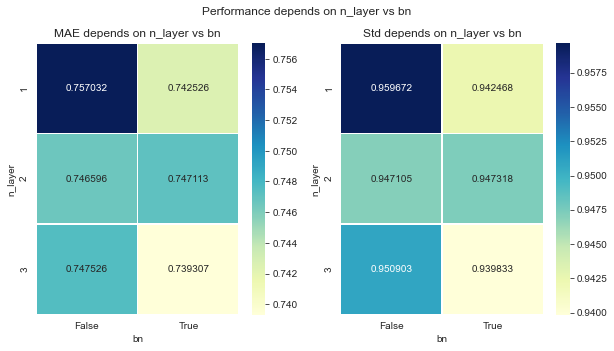

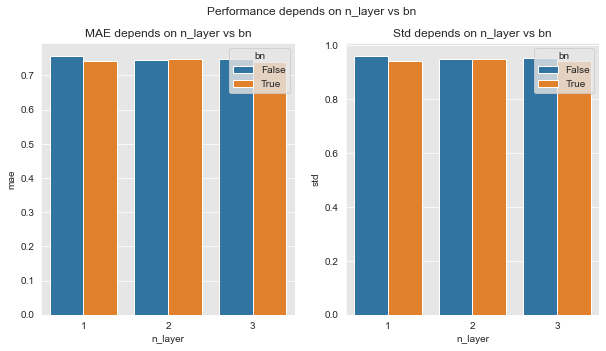

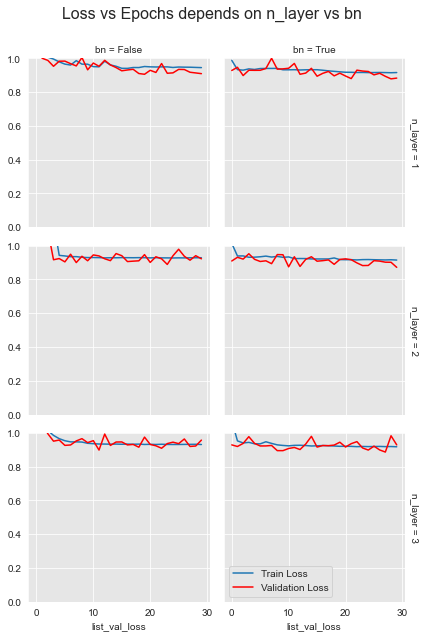

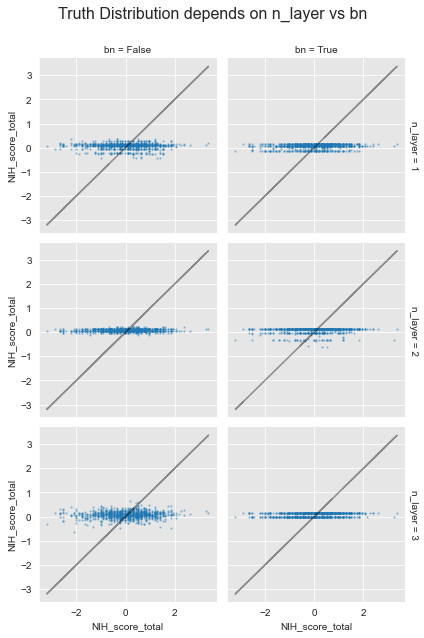

In [164]:
df_result = pd.read_json('n_layer vs bn 50000.JSON', orient='table')
var1 = "n_layer"
var2 = "bn"
plot_performance(df_result, var1, var2)
plot_performance_bar(df_result, var1, var2)
plot_loss(df_result, var1, var2)
plot_distribution(df_result, var1, var2)

# exp 2. results

bn = True // n_layer = 3

In [149]:
df_mae = df_result.pivot(var1, var2, 'mae')
df_std = df_result.pivot(var1, var2, 'std')

#df_mae[['False', 'True']]
df_mae
#df_mae = df_mae[df_mae.columns].astype(float)

bn,False,True
n_layer,,
1,0.757032,0.742526
2,0.746596,0.747113
3,0.747526,0.739307


# Experiment 3. sc vs atn

In [171]:
args.batch_size = 128
args.lr = 0.001
args.l2_coef = 0
args.optim = 'Adam'
args.epoch = 30
args.n_block = 2
args.n_layer = 3
args.n_node = 84
args.in_dim = 56
args.hidden_dim = 256
args.pred_dim1 = 256
args.pred_dim2 = 128
args.pred_dim3 = 128
args.out_dim = 1
args.bn = True
args.sc = 'no'
args.atn = False
args.num_head = 8
args.dropout = 0
args.step_size = 10
args.gamma = 0.1

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [175]:
list_sc = ['no', 'sc', 'gsc']
list_atn = [False, True]
var1 = "sc"
var2 = "atn"

dict_result = dict()
n_iter = len(list_sc)*len(list_atn)*args.epoch*(len(dict_partition['train'])+len(dict_partition['val']))
bar = tqdm_notebook(total=n_iter, file=sys.stdout, position=0)

for sc in list_sc:
    for atn in list_atn:
        args.sc = sc
        args.atn = atn
        args.exp_name = var1+':'+str(sc)+'/'+var2+':'+str(atn)
        result = vars(experiment(dict_partition, device, bar, args))
        print(args.exp_name + " took " + str(int(args.time_required)) + "seconds.")
        dict_result[args.exp_name] = copy.deepcopy(result)
        
        torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json('sc vs atn 50000.JSON', orient='table')

<ipython-input-175-ae7c81371db3>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  bar = tqdm_notebook(total=n_iter, file=sys.stdout, position=0)


  0%|          | 0/1493640 [00:00<?, ?it/s]

<ipython-input-95-b08feb65745c>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_feature = torch.tensor(batch[0]).to(device).float()
<ipython-input-95-b08feb65745c>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_adj = torch.tensor(batch[1]).to(device).float()
<ipython-input-95-b08feb65745c>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_NIH_score = torch.tensor(batch[2]).to(device).float()
<ipython-input-96-e536697e16be>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detac

sc:no/atn:False took 609seconds.


C:\Users\jungw\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
<ipython-input-95-b08feb65745c>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_feature = torch.tensor(batch[0]).to(device).float()
<ipython-input-95-b08feb65745c>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone()

sc:no/atn:True took 2276seconds.


C:\Users\jungw\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
<ipython-input-95-b08feb65745c>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_feature = torch.tensor(batch[0]).to(device).float()
<ipython-input-95-b08feb65745c>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone()

sc:sc/atn:False took 638seconds.


C:\Users\jungw\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
<ipython-input-95-b08feb65745c>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_feature = torch.tensor(batch[0]).to(device).float()
<ipython-input-95-b08feb65745c>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone()

sc:sc/atn:True took 2179seconds.


C:\Users\jungw\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
<ipython-input-95-b08feb65745c>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_feature = torch.tensor(batch[0]).to(device).float()
<ipython-input-95-b08feb65745c>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone()

sc:gsc/atn:False took 979seconds.


C:\Users\jungw\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
<ipython-input-95-b08feb65745c>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_feature = torch.tensor(batch[0]).to(device).float()
<ipython-input-95-b08feb65745c>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone()

sc:gsc/atn:True took 2654seconds.


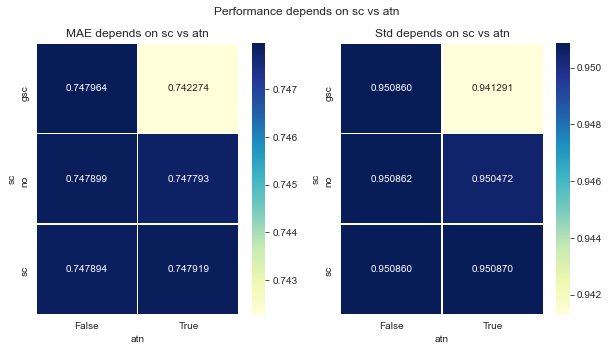

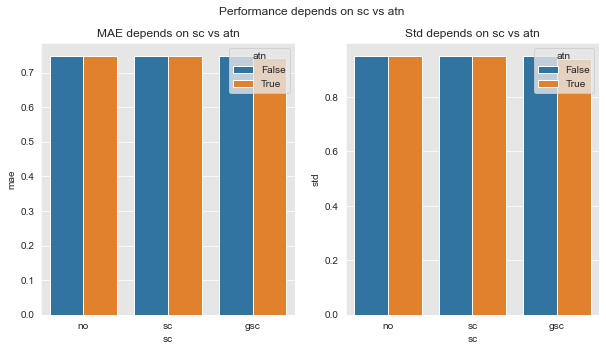

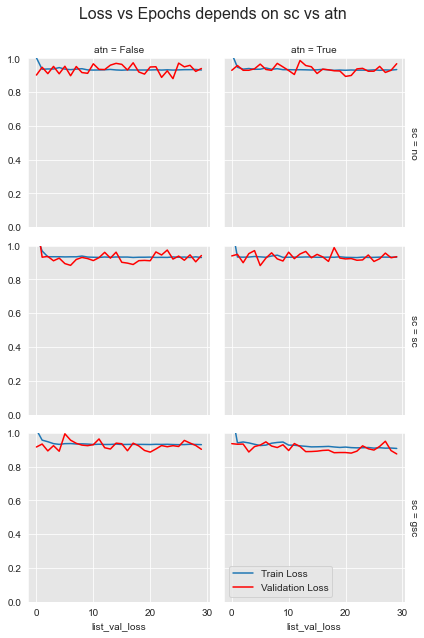

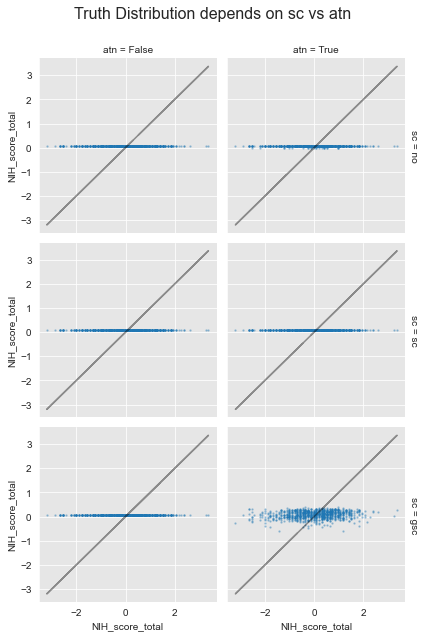

In [176]:
df_result = pd.read_json('sc vs atn 50000.JSON', orient='table')

plot_performance(df_result, var1, var2)
plot_performance_bar(df_result, var1, var2)
plot_loss(df_result, var1, var2)
plot_distribution(df_result, var1, var2)

# result of sc and atn

skip connection은 gated skip connection이 좋고, attention은 적용하는 것이 좋다

# Experiment 4. hidden_dim vs num_head

In [177]:
args.batch_size = 128
args.lr = 0.001
args.l2_coef = 0
args.optim = 'Adam'
args.epoch = 30
args.n_block = 2
args.n_layer = 3
args.n_node = 84
args.in_dim = 56
args.hidden_dim = 256
args.pred_dim1 = 256
args.pred_dim2 = 128
args.pred_dim3 = 128
args.out_dim = 1
args.bn = True
args.sc = 'gsc'
args.atn = True
args.num_head = 8
args.step_size = 10
args.gamma = 0.1
args.dropout = 0

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [178]:
list_hidden_dim = [64, 128, 256, 512]
list_num_head = [2, 4, 8, 16]
var1 = "hidden_dim"
var2 = "num_head"

dict_result = dict()
n_iter = len(list_hidden_dim)*len(list_atn)*args.epoch*(len(dict_partition['train'])+len(dict_partition['val']))
bar = tqdm_notebook(total=n_iter, file=sys.stdout, position=0)

for hidden_dim in list_hidden_dim:
    for num_head in list_num_head:
        args.hidden_dim = hidden_dim
        args.num_head = num_head
        args.exp_name = var1+':'+str(hidden_dim)+'/'+var2+':'+str(num_head)
        result = vars(experiment(dict_partition, device, bar, args))
        print(args.exp_name + " took " + str(int(args.time_required)) + "seconds.")
        dict_result[args.exp_name] = copy.deepcopy(result)
        
        torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json('hidden_dim vs num_head 50000.JSON', orient='table')

<ipython-input-178-2c51b7714950>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  bar = tqdm_notebook(total=n_iter, file=sys.stdout, position=0)


  0%|          | 0/1991520 [00:00<?, ?it/s]

C:\Users\jungw\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
<ipython-input-95-b08feb65745c>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_feature = torch.tensor(batch[0]).to(device).float()
<ipython-input-95-b08feb65745c>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone()

hidden_dim:64/num_head:2 took 482seconds.


C:\Users\jungw\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
<ipython-input-95-b08feb65745c>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_feature = torch.tensor(batch[0]).to(device).float()
<ipython-input-95-b08feb65745c>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone()

hidden_dim:64/num_head:4 took 610seconds.


C:\Users\jungw\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
<ipython-input-95-b08feb65745c>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_feature = torch.tensor(batch[0]).to(device).float()
<ipython-input-95-b08feb65745c>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone()

hidden_dim:64/num_head:8 took 930seconds.


C:\Users\jungw\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
<ipython-input-95-b08feb65745c>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_feature = torch.tensor(batch[0]).to(device).float()
<ipython-input-95-b08feb65745c>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone()

hidden_dim:64/num_head:16 took 1664seconds.


C:\Users\jungw\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
<ipython-input-95-b08feb65745c>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_feature = torch.tensor(batch[0]).to(device).float()
<ipython-input-95-b08feb65745c>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone()

hidden_dim:128/num_head:2 took 831seconds.


C:\Users\jungw\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
<ipython-input-95-b08feb65745c>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_feature = torch.tensor(batch[0]).to(device).float()
<ipython-input-95-b08feb65745c>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone()

hidden_dim:128/num_head:4 took 997seconds.


C:\Users\jungw\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
<ipython-input-95-b08feb65745c>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_feature = torch.tensor(batch[0]).to(device).float()
<ipython-input-95-b08feb65745c>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone()

hidden_dim:128/num_head:8 took 1317seconds.


C:\Users\jungw\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
<ipython-input-95-b08feb65745c>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_feature = torch.tensor(batch[0]).to(device).float()
<ipython-input-95-b08feb65745c>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone()

hidden_dim:128/num_head:16 took 2100seconds.


C:\Users\jungw\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
<ipython-input-95-b08feb65745c>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_feature = torch.tensor(batch[0]).to(device).float()
<ipython-input-95-b08feb65745c>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone()

hidden_dim:256/num_head:2 took 1778seconds.


C:\Users\jungw\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
<ipython-input-95-b08feb65745c>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_feature = torch.tensor(batch[0]).to(device).float()
<ipython-input-95-b08feb65745c>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone()

hidden_dim:256/num_head:4 took 2059seconds.


C:\Users\jungw\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
<ipython-input-95-b08feb65745c>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_feature = torch.tensor(batch[0]).to(device).float()
<ipython-input-95-b08feb65745c>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone()

hidden_dim:256/num_head:8 took 2458seconds.


C:\Users\jungw\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
<ipython-input-95-b08feb65745c>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_feature = torch.tensor(batch[0]).to(device).float()
<ipython-input-95-b08feb65745c>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone()

hidden_dim:256/num_head:16 took 3247seconds.


C:\Users\jungw\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
<ipython-input-95-b08feb65745c>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_feature = torch.tensor(batch[0]).to(device).float()
<ipython-input-95-b08feb65745c>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone()

hidden_dim:512/num_head:2 took 4659seconds.


C:\Users\jungw\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
<ipython-input-95-b08feb65745c>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_feature = torch.tensor(batch[0]).to(device).float()
<ipython-input-95-b08feb65745c>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone()

hidden_dim:512/num_head:4 took 4901seconds.


C:\Users\jungw\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
<ipython-input-95-b08feb65745c>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_feature = torch.tensor(batch[0]).to(device).float()
<ipython-input-95-b08feb65745c>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone()

hidden_dim:512/num_head:8 took 5384seconds.


C:\Users\jungw\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
<ipython-input-95-b08feb65745c>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  list_feature = torch.tensor(batch[0]).to(device).float()
<ipython-input-95-b08feb65745c>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone()

hidden_dim:512/num_head:16 took 6622seconds.


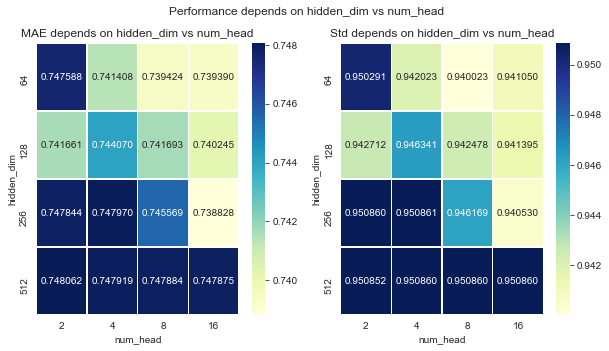

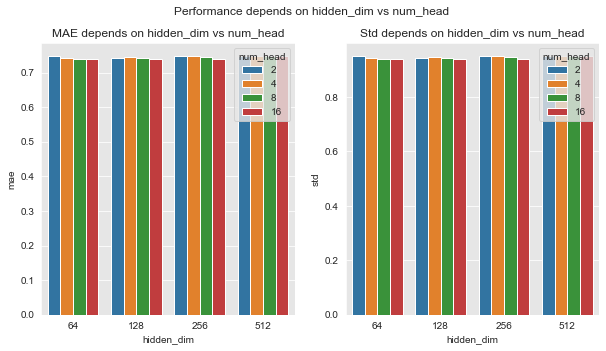

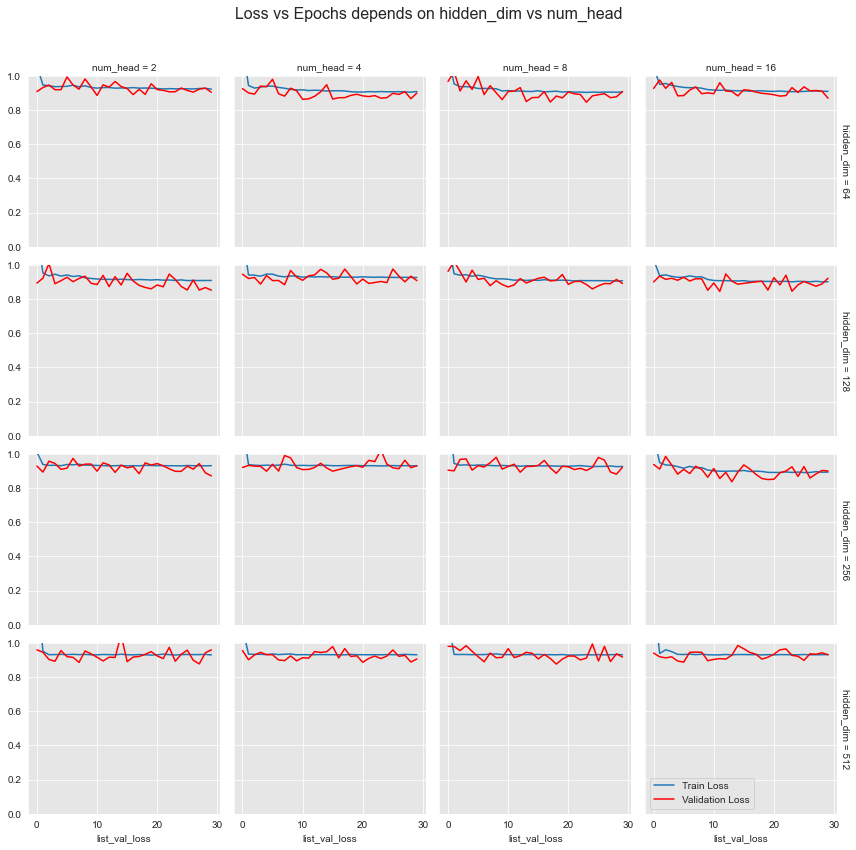

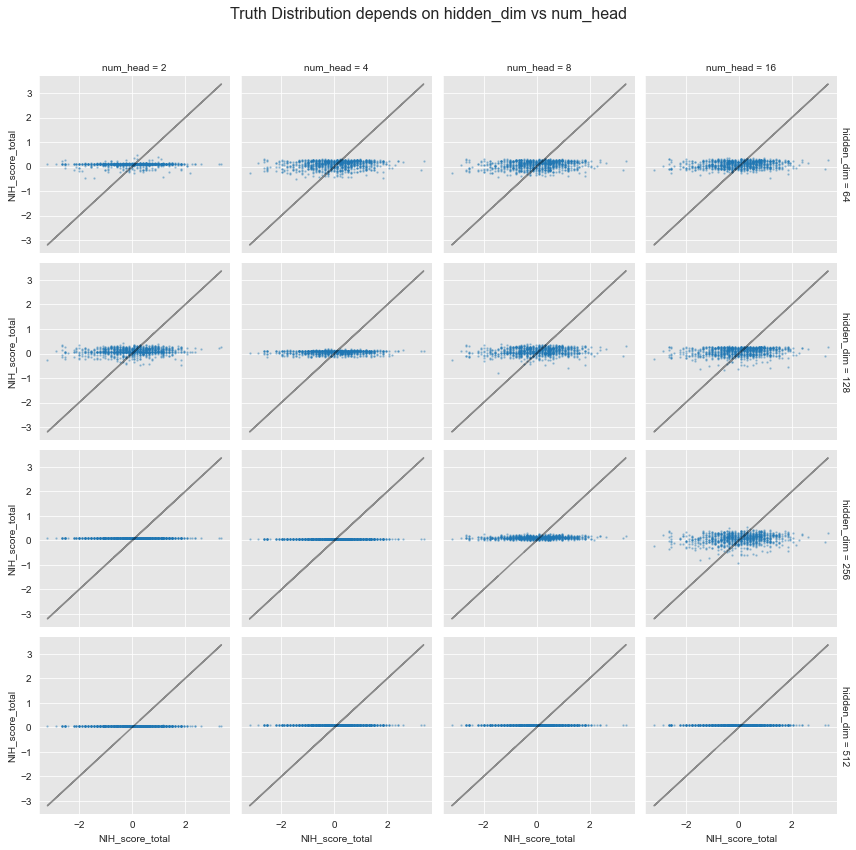

In [179]:
df_result = pd.read_json('hidden_dim vs num_head 50000.JSON', orient='table')

plot_performance(df_result, var1, var2)
plot_performance_bar(df_result, var1, var2)
plot_loss(df_result, var1, var2)
plot_distribution(df_result, var1, var2)